## Setup
Import TensorFlow and other necessary libraries:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

## Download and explore the dataset
### This project uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

flower_photo:  
- daisy  
- dandelion  
- roses  
- sunflowers  
- tulips  

In [3]:
import pathlib

datasetUrl = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
dataDir = tf.keras.utils.get_file('flower_photos.tar', origin=datasetUrl, extract=True)
dataDir = pathlib.Path(dataDir).with_suffix('')

In [4]:
imageCount = len(list(dataDir.glob('*/*.jpg'))) # checks the length of the list to confirm it downloaded all necessary images
print(imageCount)

3670


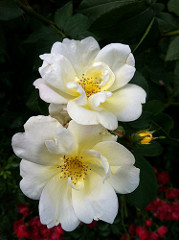

In [5]:
roses = list(dataDir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

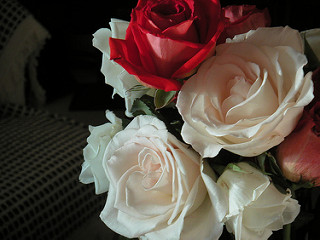

In [6]:
PIL.Image.open(str(roses[1]))

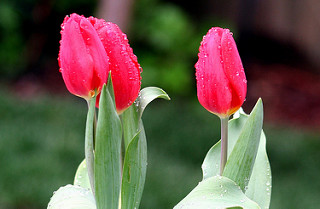

In [7]:
tulips = list(dataDir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

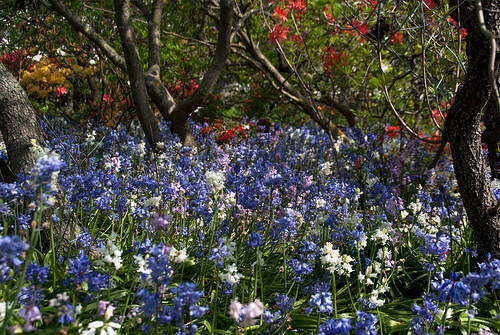

In [8]:
PIL.Image.open(str(tulips[1]))

## Create a dataset

In [9]:
batchSize = 32
imgHeight = 180
imgWidth = 180

Using the 80/20 rule where we use 80% for training and 20% for validation

In [10]:
trainingDataset = tf.keras.utils.image_dataset_from_directory(dataDir, validation_split=0.2, subset='training', seed=123, image_size=(imgHeight, imgWidth), batch_size=batchSize)
validationDataset = tf.keras.utils.image_dataset_from_directory(dataDir, validation_split=0.2, subset='validation', seed=123, image_size=(imgHeight, imgWidth), batch_size=batchSize)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


List of class names:

In [11]:
classNames = trainingDataset.class_names
print(classNames)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data
Printing out the first 25 images from the training dataset to visually see the data

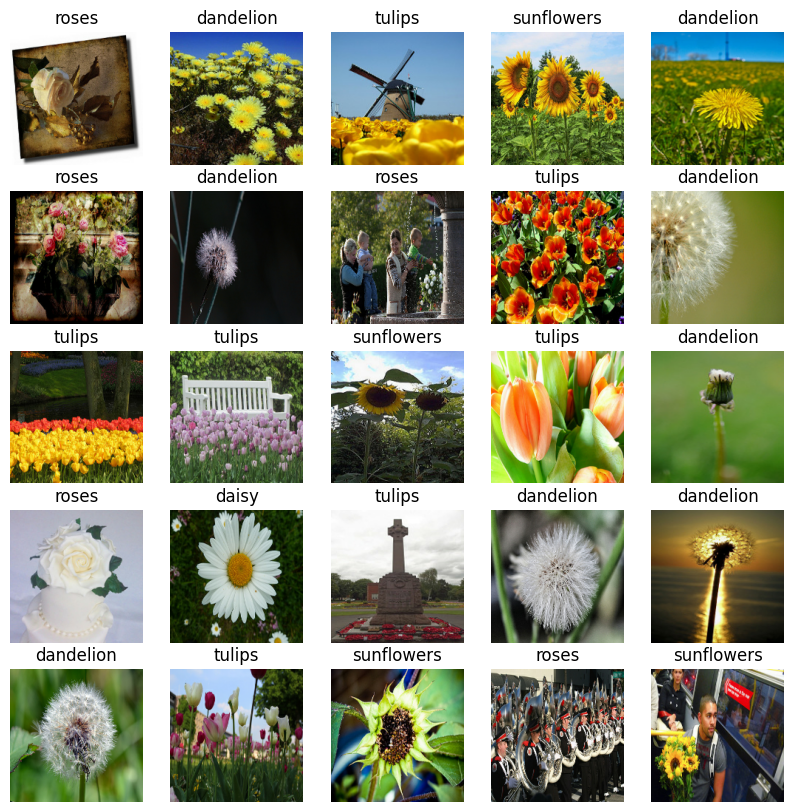

In [12]:
plt.figure(figsize=(10,10))
for imgs, lbls in trainingDataset.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(imgs[i].numpy().astype('uint8'))
        plt.title(classNames[lbls[i]])
        plt.axis('off')

## Manual iteration over the dataset

In [13]:
for imgBatch, lblBatch in trainingDataset:
    print(f'image batch (shapes, height, width, rgb) = {imgBatch.shape}')
    print(f'label batch (number of images being used) = {lblBatch.shape}')
    break

image batch (shapes, height, width, rgb) = (32, 180, 180, 3)
label batch (number of images being used) = (32,)


the image batch can be broken up into 32 image shapes of 180x180 using RGB (the 3 is a reference to RGB).  
the label batch of '32' is a reference to the 32 images being used.

## Configure the dataset for performance

In [14]:
autotune = tf.data.AUTOTUNE

trainingDataset = trainingDataset.cache().shuffle(1000).prefetch(buffer_size=autotune)
validationDataset = validationDataset.cache().prefetch(buffer_size=autotune)

## Standardize the data

In [15]:
normalLayer = layers.Rescaling(1./255)

In [16]:
normalDataset = trainingDataset.map(lambda x, y: (normalLayer(x), y))
imgBatch, lblBatch = next(iter(normalDataset))
firstImg = imgBatch[0]
print(np.min(firstImg), np.max(firstImg))

0.0 1.0


## A basic Keras model

In [17]:
numClasses = len(classNames)

mdl = Sequential([
    layers.Rescaling(1./255, input_shape = (imgHeight, imgWidth, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(numClasses)
])

## Compile the model

In [18]:
mdl.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [19]:
mdl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 16)        2

## Training the model

In [20]:
epochs = 10

history = mdl.fit(
    trainingDataset,
    validation_data= validationDataset,
    epochs= epochs
)

Epoch 1/10
92/92 [==============================] - 20s 211ms/step - loss: 1.2976 - accuracy: 0.4370 - val_loss: 1.0629 - val_accuracy: 0.5804
Epoch 2/10
92/92 [==============================] - 19s 201ms/step - loss: 1.0196 - accuracy: 0.5978 - val_loss: 1.0318 - val_accuracy: 0.5736
Epoch 3/10
92/92 [==============================] - 18s 201ms/step - loss: 0.9084 - accuracy: 0.6512 - val_loss: 0.9757 - val_accuracy: 0.5886
Epoch 4/10
92/92 [==============================] - 18s 200ms/step - loss: 0.7448 - accuracy: 0.7193 - val_loss: 0.9628 - val_accuracy: 0.6199
Epoch 5/10
92/92 [==============================] - 19s 209ms/step - loss: 0.6079 - accuracy: 0.7698 - val_loss: 0.9673 - val_accuracy: 0.6294
Epoch 6/10
92/92 [==============================] - 19s 207ms/step - loss: 0.4512 - accuracy: 0.8399 - val_loss: 1.1324 - val_accuracy: 0.5845
Epoch 7/10
92/92 [==============================] - 19s 204ms/step - loss: 0.3562 - accuracy: 0.8804 - val_loss: 1.2255 - val_accuracy: 0.5654

## Visualize the results

Text(0.5, 1.0, 'Training and Validation loss')

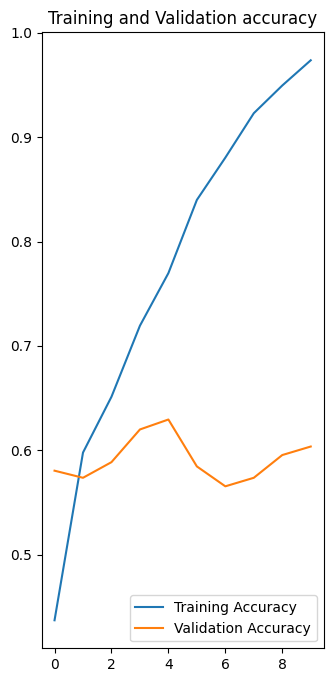

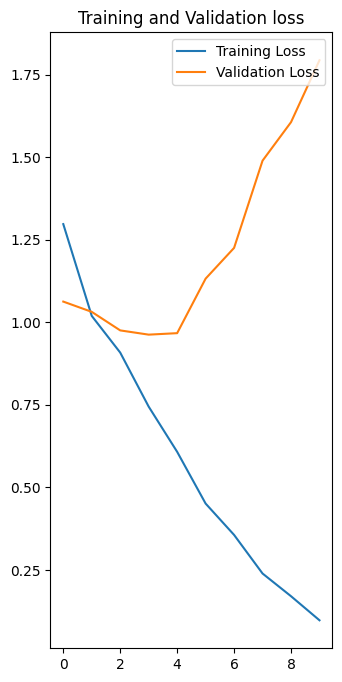

In [22]:
accuracy = history.history['accuracy']
valAccuracy = history.history['val_accuracy']
loss = history.history['loss']
valLoss = history.history['val_loss']

epochsRange = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(epochsRange, accuracy, label='Training Accuracy')
plt.plot(epochsRange, valAccuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')

plt.figure(figsize=(8, 8))
plt.subplot(1,2,2)
plt.plot(epochsRange, loss, label='Training Loss')
plt.plot(epochsRange, valLoss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
